In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

In [2]:
(x_train, _), (x_test, _) = fashion_mnist.load_data()


In [3]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.



In [4]:
x_train = x_train[..., tf.newaxis] #adds a additional axis (60000,28,28) --> (60000,28,28,1) 
x_test = x_test[..., tf.newaxis]
print(x_train.shape)
print(x_test.shape)

(60000, 28, 28, 1)
(10000, 28, 28, 1)


In [5]:
tf.random.normal(shape=x_train.shape)

<tf.Tensor: shape=(60000, 28, 28, 1), dtype=float32, numpy=
array([[[[ 1.1253549 ],
         [ 1.1953491 ],
         [ 0.20994283],
         ...,
         [-0.20759903],
         [ 0.47101167],
         [ 1.0870306 ]],

        [[ 1.6428366 ],
         [-0.9695991 ],
         [-0.13982153],
         ...,
         [-0.83209836],
         [ 2.5513363 ],
         [ 1.2195321 ]],

        [[-2.627697  ],
         [-0.24613291],
         [-0.5430019 ],
         ...,
         [-0.36418256],
         [-1.6194142 ],
         [-0.12697986]],

        ...,

        [[-1.1076053 ],
         [ 1.596041  ],
         [-0.930267  ],
         ...,
         [ 0.00314647],
         [ 0.3005419 ],
         [ 0.5342239 ]],

        [[-0.05260412],
         [ 0.02696775],
         [ 0.00891133],
         ...,
         [ 1.0066844 ],
         [-0.1158621 ],
         [ 0.6668488 ]],

        [[-0.33855116],
         [ 0.86223024],
         [ 0.4541731 ],
         ...,
         [ 0.03147848],
         [-0.300

In [6]:
noise_factor = 0.2
x_train_noisy = x_train  +  noise_factor * tf.random.normal(shape=x_train.shape) 
# noise factor multiplication result in increased spread in noise distribution
# result in 0.2^2 increase of variance, mean doesn't chnage (mean = 0) 
x_test_noisy = x_test  +  noise_factor * tf.random.normal(shape=x_test.shape) 

x_train_noisy = tf.clip_by_value(x_train_noisy, clip_value_min=0., clip_value_max=1.)
x_test_noisy = tf.clip_by_value(x_test_noisy, clip_value_min=0., clip_value_max=1.)

In [7]:
x_test_noisy.shape

TensorShape([10000, 28, 28, 1])

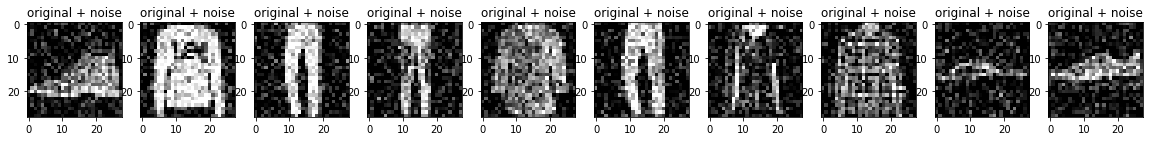

In [8]:
n = 10
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.title("original + noise")
    plt.imshow(tf.squeeze(x_test_noisy[i]))
    plt.gray()
plt.show()

In [9]:
class Denoise(Model):
    def __init__(self):
        super(Denoise, self).__init__()
        self.encoder = tf.keras.Sequential([
          layers.Input(shape=(28, 28, 1)),
          layers.Conv2D(16, (3, 3), activation='relu', padding='same', strides=2),
          layers.Conv2D(8, (3, 3), activation='relu', padding='same', strides=2)])

        self.decoder = tf.keras.Sequential([
          layers.Conv2DTranspose(8, kernel_size=3, strides=2, activation='relu', padding='same'),
          layers.Conv2DTranspose(16, kernel_size=3, strides=2, activation='relu', padding='same'),
          layers.Conv2D(1, kernel_size=(3, 3), activation='sigmoid', padding='same')])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


In [10]:
autoencoder = Denoise()

In [11]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

In [12]:
autoencoder.fit(x_train_noisy, x_train,
                epochs=10,
                shuffle=True,
                validation_data=(x_test_noisy, x_test))

Epoch 1/10
1875/1875 [==============================] - 41s 22ms/step - loss: 0.0164 - val_loss: 0.0092
Epoch 2/10
1875/1875 [==============================] - 41s 22ms/step - loss: 0.0085 - val_loss: 0.0081
Epoch 3/10
1875/1875 [==============================] - 40s 21ms/step - loss: 0.0078 - val_loss: 0.0076
Epoch 4/10
1875/1875 [==============================] - 40s 21ms/step - loss: 0.0074 - val_loss: 0.0073
Epoch 5/10
1875/1875 [==============================] - 40s 21ms/step - loss: 0.0072 - val_loss: 0.0071
Epoch 6/10
1875/1875 [==============================] - 40s 21ms/step - loss: 0.0070 - val_loss: 0.0071
Epoch 7/10
1875/1875 [==============================] - 40s 22ms/step - loss: 0.0069 - val_loss: 0.0069
Epoch 8/10
1875/1875 [==============================] - 41s 22ms/step - loss: 0.0068 - val_loss: 0.0068
Epoch 9/10
1875/1875 [==============================] - 41s 22ms/step - loss: 0.0068 - val_loss: 0.0068
Epoch 10/10
1875/1875 [==============================] - 40s 22m

In [13]:
autoencoder.encoder.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 16)        160       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 8)           1160      
Total params: 1,320
Trainable params: 1,320
Non-trainable params: 0
_________________________________________________________________


In [14]:
autoencoder.decoder.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_transpose (Conv2DTran (None, 14, 14, 8)         584       
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 28, 28, 16)        1168      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 1)         145       
Total params: 1,897
Trainable params: 1,897
Non-trainable params: 0
_________________________________________________________________


In [15]:
encoded_imgs = autoencoder.encoder(x_test_noisy).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

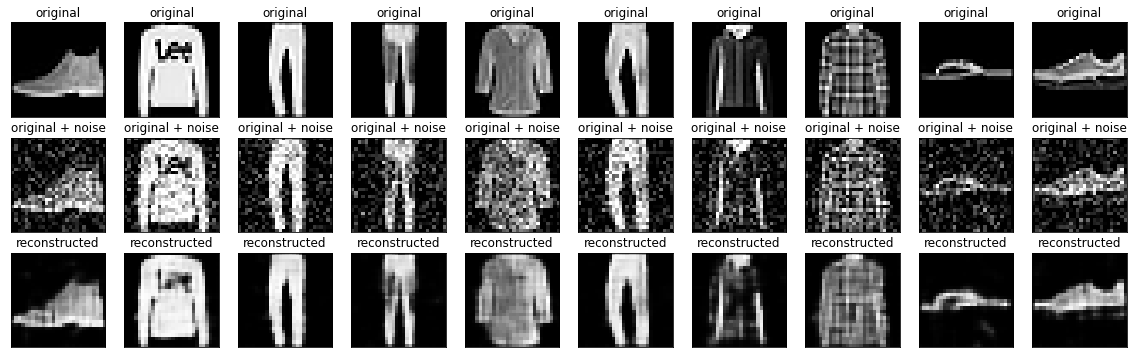

In [18]:
n = 10
plt.figure(figsize=(20, 6))
for i in range(n):
    # display original 
    ax = plt.subplot(3, n, i + 1)
    plt.title("original")
    plt.imshow(tf.squeeze(x_test[i]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # display original + noise
    ax = plt.subplot(3, n, i + n + 1)
    plt.title("original + noise")
    plt.imshow(tf.squeeze(x_test_noisy[i]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    bx = plt.subplot(3, n, i + 2*n + 1)
    plt.title("reconstructed")
    plt.imshow(tf.squeeze(decoded_imgs[i]))
    plt.gray()
    bx.get_xaxis().set_visible(False)
    bx.get_yaxis().set_visible(False)
plt.show()